#  Policy Gradients

__Автор задач: Блохин Н.В. (NVBlokhin@fa.ru)__

Материалы:
* Саттон Р. С., Барто Э. Дж. Обучение с подкреплением: Введение. 2-е изд.
* Лю Ю. (Х.) Обучение с подкреплением на PyTorch: сборник рецептов / пер. с англ. А. А. Слинкина. – М.: ДМК Пресс, 2020
* https://www.youtube.com/watch?v=_x0ASf9jV9U&ab_channel=sim0nsays
* https://karpathy.github.io/2016/05/31/rl/
* https://neerc.ifmo.ru/wiki/index.php?title=%D0%9C%D0%B5%D1%82%D0%BE%D0%B4%D1%8B_policy_gradient_%D0%B8_%D0%B0%D0%BB%D0%B3%D0%BE%D1%80%D0%B8%D1%82%D0%BC_%D0%B0%D1%81%D0%B8%D0%BD%D1%85%D1%80%D0%BE%D0%BD%D0%BD%D0%BE%D0%B3%D0%BE_%D0%B0%D0%BA%D1%82%D0%BE%D1%80%D0%B0-%D0%BA%D1%80%D0%B8%D1%82%D0%B8%D0%BA%D0%B0
* https://spinningup.openai.com/en/latest/spinningup/rl_intro3.html
* https://huggingface.co/learn/deep-rl-course/unit4/introduction
* https://lilianweng.github.io/posts/2018-04-08-policy-gradient/#:~:text=The%20goal%20of%20reinforcement%20learning,and%20optimizing%20the%20policy%20directly.

## Задачи для совместного разбора

1\. Рассмотрите основные шаги по формированию обучающей выборки для использования алгоритмов Policy Gradients.

## Задачи для самостоятельного решения

<p class="task" id="1"></p>

1\. Допишите классы `Policy` для реализации модели политики и `Trainer` для реализации процесса обучения модели при помощи алгоритма REINFORCE. Настройте агента для игры в окружении `CartPole-v1`. Визуализируйте динамику значений награды на эпизод в процессе обучения. Сыграйте эпизод, используя обученного агента, и убедитесь, что агент выучивается, как стабилизировать шест.

$$L_{PG} = -\sum_{i}{R_i\log{p(a_i|s_i)}}$$

$$R_t = \sum_{k=0}^{\infty}\gamma^kr_{t+k}$$

где $r_t$ - награда за шаг $t$.


- [ ] Проверено на семинаре

In [1]:
!apt-get install -y xvfb x11-utils
!pip install pyvirtualdisplay


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libfontenc1 libxfont2 libxkbfile1 libxtst6 libxxf86dga1 x11-xkb-utils xfonts-base
  xfonts-encodings xfonts-utils xserver-common
Suggested packages:
  mesa-utils
The following NEW packages will be installed:
  libfontenc1 libxfont2 libxkbfile1 libxtst6 libxxf86dga1 x11-utils x11-xkb-utils xfonts-base
  xfonts-encodings xfonts-utils xserver-common xvfb
0 upgraded, 12 newly installed, 0 to remove and 49 not upgraded.
Need to get 8,046 kB of archives.
After this operation, 12.8 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 libfontenc1 amd64 1:1.1.4-1build3 [14.7 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 libxfont2 amd64 1:2.0.5-1build1 [94.5 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/main amd64 libxkbfile1 amd64 1:1.1.0-1build3 [71.8 kB]
Get:4 http://archive.ubuntu.

In [2]:
import torch as th
import torch.nn as nn
import torch.optim as optim
import numpy as np
import io
import gym
import matplotlib.pyplot as plt
from dataclasses import dataclass
from torch.distributions import Categorical
import pyvirtualdisplay
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

In [2]:
from dataclasses import dataclass
@dataclass
class PolicyConfig:
    n_state: int
    n_action: int
    n_hidden: int

In [3]:
class PolicyNetwork(nn.Module):
    def __init__(self, policy_config: PolicyConfig):
        super().__init__()
        self.cfg = policy_config
        self.model = nn.Sequential(
            nn.Linear(self.cfg.n_state, self.cfg.n_hidden),  # Входной слой
            nn.ReLU(),
            nn.Linear(self.cfg.n_hidden, self.cfg.n_action),  # Выходной слой
            nn.Softmax(dim=-1)  # Softmax для получения вероятностей действий
        )

    def forward(self, s: th.Tensor) -> th.Tensor:
        return self.model(s)

    def get_action(self, s: th.Tensor) -> tuple[int, float]:
        # Считаем вероятности действий
        probs = self.forward(s)
        # Categorical распределение на основе вероятностей
        m = Categorical(probs)
        action = m.sample()  # Выбираем действие на основе вероятностей
        log_prob = m.log_prob(action)  # Логарифм вероятности выбранного действия
        return action.item(), log_prob

In [4]:
from dataclasses import dataclass

@dataclass
class TrainConfig:
    gamma: float = 0.99  # Дисконтирование
    learning_rate: float = 0.001  # Скорость обучения
    episode_num: int = 400  # Количество эпизодов
    max_timesteps: int = 1000  # Максимальное количество шагов в эпизоде

class Trainer:
    def __init__(self, env, policy_network: PolicyNetwork, train_config: TrainConfig):
        self.env = env
        self.policy_network = policy_network
        self.train_config = train_config
        self.optimizer = optim.Adam(self.policy_network.parameters(), lr=self.train_config.learning_rate)
        self.gamma = self.train_config.gamma
        self.episode_num = self.train_config.episode_num

    def compute_returns(self, rewards: list) -> th.Tensor:
        # Рассчитываем дисконтированные награды
        returns = th.zeros(len(rewards))
        G = 0
        for t in reversed(range(len(rewards))):
            G = rewards[t] + self.gamma * G
            returns[t] = G
        return returns

    def train(self):
        episode_rewards = []
        for episode in range(self.episode_num):
            state = self.env.reset()
            done = False
            episode_rewards_this = []
            log_probs = []
            rewards = []

            # Эпизод
            for t in range(self.train_config.max_timesteps):
                state_tensor = th.tensor(state, dtype=th.float32)
                action, log_prob = self.policy_network.get_action(state_tensor)

                next_state, reward, done, _ = self.env.step(action)

                log_probs.append(log_prob)
                rewards.append(reward)
                state = next_state
                episode_rewards_this.append(reward)

                if done:
                    break

            # Расчет итоговых вознаграждений
            returns = self.compute_returns(rewards)
            returns = (returns - returns.mean()) / (returns.std() + 1e-9)  # Нормализация

            # Обновление параметров сети
            self.optimizer.zero_grad()
            loss = 0
            for log_prob, G in zip(log_probs, returns):
                loss -= log_prob * G  # REINFORCE loss

            loss.backward()
            self.optimizer.step()

            # Сохранение награды за эпизод
            episode_rewards.append(np.sum(episode_rewards_this))

            # Печать прогресса
            if episode % 10 == 0:
                print(f'Episode {episode}/{self.episode_num}, Loss: {loss.item():.3f}')

        return episode_rewards

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episode 0/400, Loss: 0.018
Episode 10/400, Loss: 0.104
Episode 20/400, Loss: 0.074
Episode 30/400, Loss: -0.086
Episode 40/400, Loss: -0.071
Episode 50/400, Loss: -0.344
Episode 60/400, Loss: -0.633
Episode 70/400, Loss: 0.200
Episode 80/400, Loss: 0.388
Episode 90/400, Loss: -2.525
Episode 100/400, Loss: 0.127
Episode 110/400, Loss: -1.887
Episode 120/400, Loss: -2.859
Episode 130/400, Loss: 0.543
Episode 140/400, Loss: -1.182
Episode 150/400, Loss: -0.187
Episode 160/400, Loss: -0.778
Episode 170/400, Loss: 0.248
Episode 180/400, Loss: -2.177
Episode 190/400, Loss: 2.248
Episode 200/400, Loss: -3.482
Episode 210/400, Loss: -5.064
Episode 220/400, Loss: 0.115
Episode 230/400, Loss: 1.693
Episode 240/400, Loss: 2.836
Episode 250/400, Loss: -1.569
Episode 260/400, Loss: -0.787
Episode 270/400, Loss: 0.810
Episode 280/400, Loss: -1.930
Episode 290/400, Loss: -1.270
Episode 300/400, Loss: 0.052
Episode 310/400, Loss: 3.230
Episode 320/400, Loss: 4.325
Episode 330/400, Loss: 2.930
Episode 

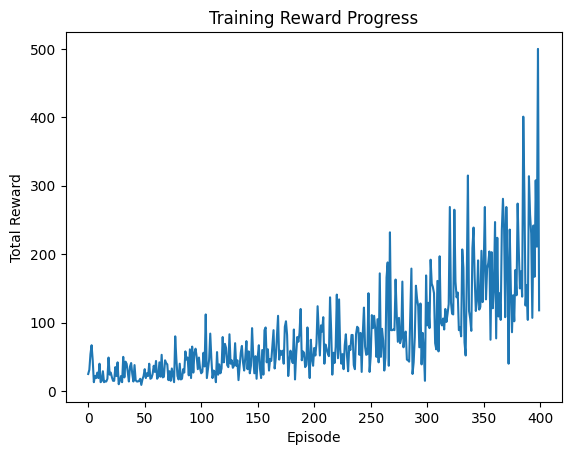

In [5]:
# Создаем среду CartPole
env = gym.make('CartPole-v1')

# Инициализируем конфигурацию модели политики
policy_config = PolicyConfig(n_state=env.observation_space.shape[0], n_action=env.action_space.n, n_hidden=128)
policy_network = PolicyNetwork(policy_config)

# Настройка тренера
train_config = TrainConfig(episode_num=400, gamma=0.99, learning_rate=0.001)
trainer = Trainer(env, policy_network, train_config)

# Обучаем модель
episode_rewards = trainer.train()

# Визуализация награды
plt.plot(episode_rewards)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Training Reward Progress')
plt.show()


In [6]:
# Тестирование обученного агента
state = env.reset()
done = False
while not done:
    state_tensor = th.tensor(state, dtype=th.float32)
    action, _ = policy_network.get_action(state_tensor)
    next_state, reward, done, _ = env.step(action)
    env.render()
    state = next_state
env.close()


/usr/local/lib/python3.10/dist-packages/gym/core.py:49: DeprecationWarning: WARN: You are calling render method, but you didn't specified the argument render_mode at environment initialization. To maintain backward compatibility, the environment will render in human mode.
If you want to render in human mode, initialize the environment in this way: gym.make('EnvName', render_mode='human') and don't call the render method.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(
/usr/local/lib/python3.10/dist-packages/pygame/pkgdata.py:25: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import resource_stream, resource_exists
/usr/local/lib/python3.10/dist-packages/pkg_resources/__init__.py:3154: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_reso

<p class="task" id="2"></p>

2\. Повторите решение задачи 1, делая шаг обучения не после одного эпизода, а по результату прогонов нескольких эпизодов. Обратите внимание, что после обновления весов модели все старые данные для обучения становятся неактуальными и должны быть удалены.

- [ ] Проверено на семинаре

In [7]:
@dataclass
class PolicyConfig:
    n_state: int
    n_action: int
    n_hidden: int

class PolicyNetwork(nn.Module):
    def __init__(self, policy_config: PolicyConfig):
        super().__init__()
        self.cfg = policy_config
        self.model = nn.Sequential(
            nn.Linear(self.cfg.n_state, self.cfg.n_hidden),  # Входной слой
            nn.ReLU(),
            nn.Linear(self.cfg.n_hidden, self.cfg.n_action),  # Выходной слой
            nn.Softmax(dim=-1)  # Softmax для получения вероятностей действий
        )

    def forward(self, s: th.Tensor) -> th.Tensor:
        return self.model(s)

    def get_action(self, s: th.Tensor) -> tuple[int, float]:
        # Считаем вероятности действий
        probs = self.forward(s)
        # Categorical распределение на основе вероятностей
        m = Categorical(probs)
        action = m.sample()  # Выбираем действие на основе вероятностей
        log_prob = m.log_prob(action)  # Логарифм вероятности выбранного действия
        return action.item(), log_prob

In [8]:
@dataclass
class TrainConfig:
    gamma: float = 0.99  # Дисконтирование
    learning_rate: float = 0.001  # Скорость обучения
    episode_num: int = 400  # Количество эпизодов
    max_timesteps: int = 1000  # Максимальное количество шагов в эпизоде
    batch_size: int = 10  # Количество эпизодов для одного обновления

class Trainer:
    def __init__(self, env, policy_network: PolicyNetwork, train_config: TrainConfig):
        self.env = env
        self.policy_network = policy_network
        self.train_config = train_config
        self.optimizer = optim.Adam(self.policy_network.parameters(), lr=self.train_config.learning_rate)
        self.gamma = self.train_config.gamma
        self.batch_size = self.train_config.batch_size

    def compute_returns(self, rewards: list) -> th.Tensor:
        # Рассчитываем дисконтированные награды
        returns = th.zeros(len(rewards))
        G = 0
        for t in reversed(range(len(rewards))):
            G = rewards[t] + self.gamma * G
            returns[t] = G
        return returns

    def train(self):
        episode_rewards = []
        log_probs_all = []
        rewards_all = []

        for episode in range(self.train_config.episode_num):
            state = self.env.reset()
            done = False
            episode_rewards_this = []
            log_probs = []
            rewards = []

            # Эпизод
            for t in range(self.train_config.max_timesteps):
                state_tensor = th.tensor(state, dtype=th.float32)
                action, log_prob = self.policy_network.get_action(state_tensor)

                next_state, reward, done, _ = self.env.step(action)

                log_probs.append(log_prob)
                rewards.append(reward)
                state = next_state
                episode_rewards_this.append(reward)

                if done:
                    break

            # Добавляем данные в общую память
            log_probs_all.extend(log_probs)
            rewards_all.extend(rewards)
            episode_rewards.append(np.sum(episode_rewards_this))

            # Печать прогресса
            if episode % 10 == 0:
                print(f'Episode {episode}/{self.train_config.episode_num}, Total Reward: {np.sum(episode_rewards_this)}')

            # Если накопилось достаточно эпизодов, обновляем модель
            if (episode + 1) % self.batch_size == 0:
                # Рассчитываем итоговые вознаграждения
                returns = self.compute_returns(rewards_all)
                returns = (returns - returns.mean()) / (returns.std() + 1e-9)  # Нормализация

                # Обновление параметров сети
                self.optimizer.zero_grad()
                loss = 0
                for log_prob, G in zip(log_probs_all, returns):
                    loss -= log_prob * G  # REINFORCE loss

                loss.backward()
                self.optimizer.step()

                # Очищаем старые данные
                log_probs_all = []
                rewards_all = []

        return episode_rewards

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episode 0/400, Total Reward: 16.0
Episode 10/400, Total Reward: 29.0
Episode 20/400, Total Reward: 21.0
Episode 30/400, Total Reward: 15.0
Episode 40/400, Total Reward: 14.0
Episode 50/400, Total Reward: 41.0
Episode 60/400, Total Reward: 17.0
Episode 70/400, Total Reward: 63.0
Episode 80/400, Total Reward: 17.0
Episode 90/400, Total Reward: 29.0
Episode 100/400, Total Reward: 11.0
Episode 110/400, Total Reward: 27.0
Episode 120/400, Total Reward: 21.0
Episode 130/400, Total Reward: 22.0
Episode 140/400, Total Reward: 19.0
Episode 150/400, Total Reward: 27.0
Episode 160/400, Total Reward: 16.0
Episode 170/400, Total Reward: 17.0
Episode 180/400, Total Reward: 30.0
Episode 190/400, Total Reward: 13.0
Episode 200/400, Total Reward: 17.0
Episode 210/400, Total Reward: 21.0
Episode 220/400, Total Reward: 28.0
Episode 230/400, Total Reward: 36.0
Episode 240/400, Total Reward: 21.0
Episode 250/400, Total Reward: 14.0
Episode 260/400, Total Reward: 77.0
Episode 270/400, Total Reward: 14.0
Epi

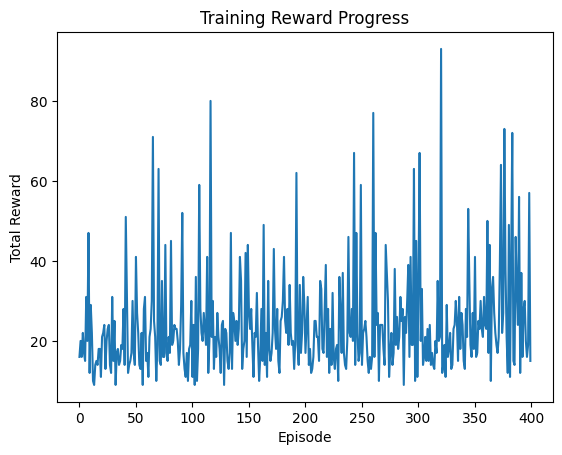

In [9]:
# Создаем среду CartPole
env = gym.make('CartPole-v1')

# Инициализируем конфигурацию модели политики
policy_config = PolicyConfig(n_state=env.observation_space.shape[0], n_action=env.action_space.n, n_hidden=128)
policy_network = PolicyNetwork(policy_config)

# Настройка тренера
train_config = TrainConfig(episode_num=400, gamma=0.99, learning_rate=0.001, batch_size=10)
trainer = Trainer(env, policy_network, train_config)

# Обучаем модель
episode_rewards = trainer.train()

# Визуализация награды
plt.plot(episode_rewards)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Training Reward Progress')
plt.show()


In [11]:
# Тестирование обученного агента
state = env.reset()
done = False
while not done:
    state_tensor = th.tensor(state, dtype=th.float32)
    action, _ = policy_network.get_action(state_tensor)
    next_state, reward, done, _ = env.step(action)
    env.render()
    state = next_state
env.close()


error: display Surface quit

<p class="task" id="3"></p>

3\. Повторите решение задачи 1, реализовав алгоритм REINFONCE с baseline.

$$L_{PG} = -\sum_{i}{A_i\log{p(a_i|s_i)}}$$

$$A_i = R_i - V(s_i)$$

$$R_t = \sum_{k=0}^{\infty}\gamma^kr_{t+k}$$

где $r_t$ - награда за шаг $t$.

$p(a_i|s_i)$ и $V(s_i)$ моделируются при помощи двух независимых сетей. Сеть для политики настраивается аналогично задаче 1 и 2 при помощи функции потерь $L_{PG}$. Сеть для оценки базы настраивается в процессе решения задачи регрессии: $L_{V} = \sum_i(V(s_i) - R_i)^2$. Настройка весов обеих моделей происходит после каждого эпизода.

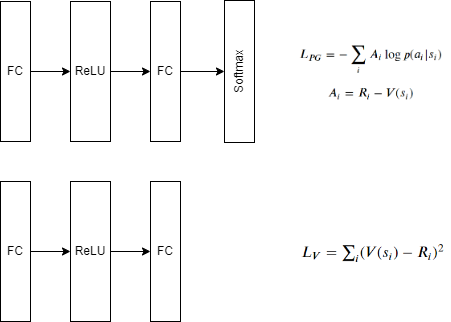

- [ ] Проверено на семинаре

In [12]:
@dataclass
class PolicyConfig:
    n_state: int
    n_action: int
    n_hidden: int

# Сеть для политики
class PolicyNetwork(nn.Module):
    def __init__(self, policy_config: PolicyConfig):
        super().__init__()
        self.cfg = policy_config
        self.model = nn.Sequential(
            nn.Linear(self.cfg.n_state, self.cfg.n_hidden),  # Входной слой
            nn.ReLU(),
            nn.Linear(self.cfg.n_hidden, self.cfg.n_action),  # Выходной слой
            nn.Softmax(dim=-1)  # Softmax для получения вероятностей действий
        )

    def forward(self, s: th.Tensor) -> th.Tensor:
        return self.model(s)

    def get_action(self, s: th.Tensor) -> tuple[int, float]:
        # Считаем вероятности действий
        probs = self.forward(s)
        # Categorical распределение на основе вероятностей
        m = Categorical(probs)
        action = m.sample()  # Выбираем действие на основе вероятностей
        log_prob = m.log_prob(action)  # Логарифм вероятности выбранного действия
        return action.item(), log_prob

In [13]:
# Сеть для оценки ценности
class ValueNetwork(nn.Module):
    def __init__(self, policy_config: PolicyConfig):
        super().__init__()
        self.cfg = policy_config
        self.model = nn.Sequential(
            nn.Linear(self.cfg.n_state, self.cfg.n_hidden),  # Входной слой
            nn.ReLU(),
            nn.Linear(self.cfg.n_hidden, 1)  # Оценка ценности (одиночное значение)
        )

    def forward(self, s: th.Tensor) -> th.Tensor:
        return self.model(s)

In [14]:
@dataclass
class TrainConfig:
    gamma: float = 0.99  # Дисконтирование
    learning_rate: float = 0.001  # Скорость обучения
    episode_num: int = 400  # Количество эпизодов
    max_timesteps: int = 1000  # Максимальное количество шагов в эпизоде

class Trainer:
    def __init__(self, env, policy_network: PolicyNetwork, value_network: ValueNetwork, train_config: TrainConfig):
        self.env = env
        self.policy_network = policy_network
        self.value_network = value_network
        self.train_config = train_config
        self.optimizer_policy = optim.Adam(self.policy_network.parameters(), lr=self.train_config.learning_rate)
        self.optimizer_value = optim.Adam(self.value_network.parameters(), lr=self.train_config.learning_rate)
        self.gamma = self.train_config.gamma
        self.episode_num = self.train_config.episode_num

    def compute_returns(self, rewards: list) -> th.Tensor:
        # Рассчитываем дисконтированные награды
        returns = th.zeros(len(rewards))
        G = 0
        for t in reversed(range(len(rewards))):
            G = rewards[t] + self.gamma * G
            returns[t] = G
        return returns

    def train(self):
        episode_rewards = []

        for episode in range(self.episode_num):
            state = self.env.reset()
            done = False
            episode_rewards_this = []
            log_probs = []
            rewards = []
            values = []

            # Эпизод
            for t in range(self.train_config.max_timesteps):
                state_tensor = th.tensor(state, dtype=th.float32)

                # Получаем действие от политики и вычисляем его ценность
                action, log_prob = self.policy_network.get_action(state_tensor)
                value = self.value_network(state_tensor)  # Оценка ценности для состояния

                next_state, reward, done, _ = self.env.step(action)

                log_probs.append(log_prob)
                rewards.append(reward)
                values.append(value)
                state = next_state
                episode_rewards_this.append(reward)

                if done:
                    break

            # Рассчитываем итоговые вознаграждения
            returns = self.compute_returns(rewards)
            returns = (returns - returns.mean()) / (returns.std() + 1e-9)  # Нормализация

            # Обновление функции ценности
            returns_tensor = th.tensor(returns, dtype=th.float32).view(-1, 1)
            values_tensor = th.stack(values)  # Преобразуем список значений в тензор
            value_loss = nn.MSELoss()(values_tensor, returns_tensor)  # Функция потерь для оценки ценности

            # Обновление сети оценки ценности
            self.optimizer_value.zero_grad()
            value_loss.backward()
            self.optimizer_value.step()

            # Вычисление улучшенной награды
            advantages = returns_tensor - values_tensor.detach()  # A = R - V(s)

            # Обновление политики (REINFORCE с baseline)
            policy_loss = -th.sum(advantages * th.stack(log_probs))  # Функция потерь для политики

            self.optimizer_policy.zero_grad()
            policy_loss.backward()
            self.optimizer_policy.step()

            # Сохранение награды за эпизод
            episode_rewards.append(np.sum(episode_rewards_this))

            # Печать прогресса
            if episode % 10 == 0:
                print(f'Episode {episode}/{self.episode_num}, Total Reward: {np.sum(episode_rewards_this)}')

        return episode_rewards


<ipython-input-14-9bfde40a2495>:63: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  returns_tensor = th.tensor(returns, dtype=th.float32).view(-1, 1)


Episode 0/400, Total Reward: 22.0
Episode 10/400, Total Reward: 15.0
Episode 20/400, Total Reward: 17.0
Episode 30/400, Total Reward: 31.0
Episode 40/400, Total Reward: 12.0
Episode 50/400, Total Reward: 20.0
Episode 60/400, Total Reward: 15.0
Episode 70/400, Total Reward: 11.0
Episode 80/400, Total Reward: 9.0
Episode 90/400, Total Reward: 13.0
Episode 100/400, Total Reward: 10.0
Episode 110/400, Total Reward: 17.0
Episode 120/400, Total Reward: 10.0
Episode 130/400, Total Reward: 10.0
Episode 140/400, Total Reward: 11.0
Episode 150/400, Total Reward: 10.0
Episode 160/400, Total Reward: 12.0
Episode 170/400, Total Reward: 12.0
Episode 180/400, Total Reward: 12.0
Episode 190/400, Total Reward: 10.0
Episode 200/400, Total Reward: 10.0
Episode 210/400, Total Reward: 11.0
Episode 220/400, Total Reward: 8.0
Episode 230/400, Total Reward: 9.0
Episode 240/400, Total Reward: 10.0
Episode 250/400, Total Reward: 9.0
Episode 260/400, Total Reward: 11.0
Episode 270/400, Total Reward: 8.0
Episode 

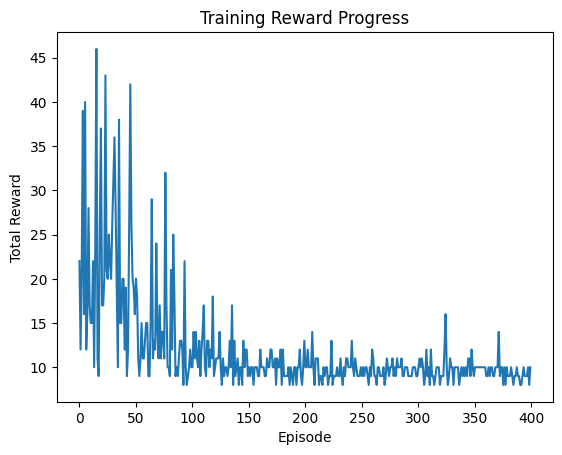

In [15]:
# Создаем среду CartPole
env = gym.make('CartPole-v1')

# Инициализируем конфигурацию модели политики
policy_config = PolicyConfig(n_state=env.observation_space.shape[0], n_action=env.action_space.n, n_hidden=128)
policy_network = PolicyNetwork(policy_config)
value_network = ValueNetwork(policy_config)

# Настройка тренера
train_config = TrainConfig(episode_num=400, gamma=0.99, learning_rate=0.001)
trainer = Trainer(env, policy_network, value_network, train_config)

# Обучаем модель
episode_rewards = trainer.train()

# Визуализация награды
plt.plot(episode_rewards)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Training Reward Progress')
plt.show()


In [16]:
# Тестирование обученного агента
state = env.reset()
done = False
while not done:
    state_tensor = th.tensor(state, dtype=th.float32)
    action, _ = policy_network.get_action(state_tensor)
    next_state, reward, done, _ = env.step(action)
    env.render()
    state = next_state
env.close()


<p class="task" id="4"></p>

4\. Повторите решение задачи 1, реализовав алгоритм Actor-Critic

$$L_{PG} = -\sum_{i}{A_i\log{p(a_i|s_i)}}$$

$$A_i = R_i - V(s_i)$$

$$R_t = \sum_{k=0}^{\infty}\gamma^kr_{t+k}$$

где $r_t$ - награда за шаг $t$.

$p(a_i|s_i)$ и $V(s_i)$ моделируются при помощи одной сети в двумя головами. Голова для политики настраивается аналогично задаче 1 и 2 при помощи функции потерь $L_{PG}$. Голова для оценки базы настраивается в процессе решения задачи регрессии: $L_{V} = \sum_i(V(s_i) - R_i)^2$. Итоговая функции потерь для настройки представляет из себя сумму функций потерь для голов: $L = L_{PG} + L_{V}$.

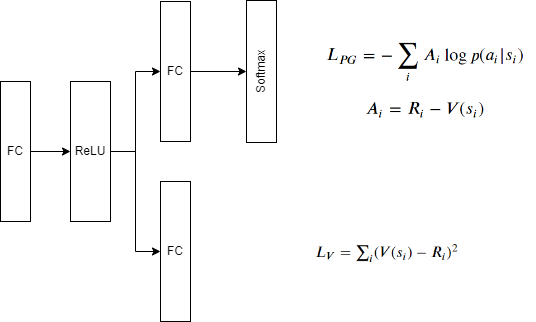

- [ ] Проверено на семинаре

In [17]:
@dataclass
class PolicyConfig:
    n_state: int
    n_action: int
    n_hidden: int

# Сеть с двумя головами: для политики и для ценности
class ActorCriticNetwork(nn.Module):
    def __init__(self, policy_config: PolicyConfig):
        super().__init__()
        self.cfg = policy_config
        self.shared = nn.Sequential(
            nn.Linear(self.cfg.n_state, self.cfg.n_hidden),
            nn.ReLU()
        )

        # Голова для политики
        self.policy_head = nn.Linear(self.cfg.n_hidden, self.cfg.n_action)  # Выход для вероятностей действий

        # Голова для критика (оценка ценности)
        self.value_head = nn.Linear(self.cfg.n_hidden, 1)  # Выход для оценки ценности состояния

    def forward(self, s: th.Tensor) -> th.Tensor:
        shared_out = self.shared(s)
        action_probs = th.softmax(self.policy_head(shared_out), dim=-1)
        state_value = self.value_head(shared_out)
        return action_probs, state_value

    def get_action(self, s: th.Tensor) -> tuple[int, float]:
        action_probs, _ = self.forward(s)
        m = Categorical(action_probs)
        action = m.sample()
        log_prob = m.log_prob(action)
        return action.item(), log_prob

In [18]:
@dataclass
class TrainConfig:
    gamma: float = 0.99  # Дисконтирование
    learning_rate: float = 0.001  # Скорость обучения
    episode_num: int = 400  # Количество эпизодов
    max_timesteps: int = 1000  # Максимальное количество шагов в эпизоде

class ActorCriticTrainer:
    def __init__(self, env, actor_critic: ActorCriticNetwork, train_config: TrainConfig):
        self.env = env
        self.actor_critic = actor_critic
        self.train_config = train_config
        self.optimizer = optim.Adam(self.actor_critic.parameters(), lr=self.train_config.learning_rate)
        self.gamma = self.train_config.gamma
        self.episode_num = self.train_config.episode_num

    def compute_returns(self, rewards: list) -> th.Tensor:
        # Рассчитываем дисконтированные награды
        returns = th.zeros(len(rewards))
        G = 0
        for t in reversed(range(len(rewards))):
            G = rewards[t] + self.gamma * G
            returns[t] = G
        return returns

    def train(self):
        episode_rewards = []

        for episode in range(self.episode_num):
            state = self.env.reset()
            done = False
            episode_rewards_this = []
            log_probs = []
            rewards = []
            values = []

            # Эпизод
            for t in range(self.train_config.max_timesteps):
                state_tensor = th.tensor(state, dtype=th.float32)

                # Получаем действия и ценности
                action, log_prob = self.actor_critic.get_action(state_tensor)
                _, value = self.actor_critic(state_tensor)  # Оценка ценности для состояния

                next_state, reward, done, _ = self.env.step(action)

                log_probs.append(log_prob)
                rewards.append(reward)
                values.append(value)
                state = next_state
                episode_rewards_this.append(reward)

                if done:
                    break

            # Рассчитываем итоговые вознаграждения
            returns = self.compute_returns(rewards)
            returns = (returns - returns.mean()) / (returns.std() + 1e-9)  # Нормализация

            # Обновление функции ценности (критика)
            returns_tensor = th.tensor(returns, dtype=th.float32).view(-1, 1)
            values_tensor = th.stack(values)  # Преобразуем список значений в тензор
            value_loss = nn.MSELoss()(values_tensor, returns_tensor)  # Функция потерь для критика

            # Обновление политики (актора)
            advantages = returns_tensor - values_tensor.detach()  # A = R - V(s)
            policy_loss = -th.sum(advantages * th.stack(log_probs))  # Функция потерь для политики

            # Итоговая функция потерь
            total_loss = policy_loss + value_loss

            # Обновление параметров
            self.optimizer.zero_grad()
            total_loss.backward()
            self.optimizer.step()

            # Сохранение награды за эпизод
            episode_rewards.append(np.sum(episode_rewards_this))

            # Печать прогресса
            if episode % 10 == 0:
                print(f'Episode {episode}/{self.episode_num}, Total Reward: {np.sum(episode_rewards_this)}')

        return episode_rewards


<ipython-input-18-846d7c7640b9>:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  returns_tensor = th.tensor(returns, dtype=th.float32).view(-1, 1)


Episode 0/400, Total Reward: 19.0
Episode 10/400, Total Reward: 18.0
Episode 20/400, Total Reward: 17.0
Episode 30/400, Total Reward: 19.0
Episode 40/400, Total Reward: 10.0
Episode 50/400, Total Reward: 22.0
Episode 60/400, Total Reward: 9.0
Episode 70/400, Total Reward: 11.0
Episode 80/400, Total Reward: 11.0
Episode 90/400, Total Reward: 11.0
Episode 100/400, Total Reward: 9.0
Episode 110/400, Total Reward: 11.0
Episode 120/400, Total Reward: 9.0
Episode 130/400, Total Reward: 9.0
Episode 140/400, Total Reward: 11.0
Episode 150/400, Total Reward: 10.0
Episode 160/400, Total Reward: 10.0
Episode 170/400, Total Reward: 8.0
Episode 180/400, Total Reward: 10.0
Episode 190/400, Total Reward: 9.0
Episode 200/400, Total Reward: 10.0
Episode 210/400, Total Reward: 9.0
Episode 220/400, Total Reward: 9.0
Episode 230/400, Total Reward: 10.0
Episode 240/400, Total Reward: 12.0
Episode 250/400, Total Reward: 9.0
Episode 260/400, Total Reward: 8.0
Episode 270/400, Total Reward: 9.0
Episode 280/40

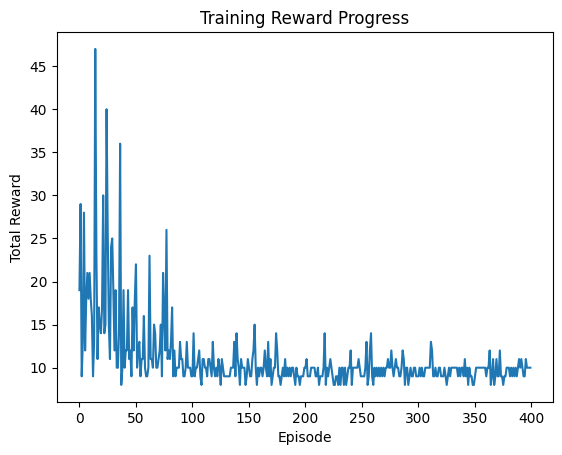

In [26]:
# Создаем среду CartPole
env = gym.make('CartPole-v1')

# Инициализируем конфигурацию модели
policy_config = PolicyConfig(n_state=env.observation_space.shape[0], n_action=env.action_space.n, n_hidden=128)
actor_critic_network = ActorCriticNetwork(policy_config)

# Настройка тренера
train_config = TrainConfig(episode_num=400, gamma=0.99, learning_rate=0.001)
trainer = ActorCriticTrainer(env, actor_critic_network, train_config)

# Обучаем модель
episode_rewards = trainer.train()

# Визуализация награды
plt.plot(episode_rewards)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Training Reward Progress')
plt.show()


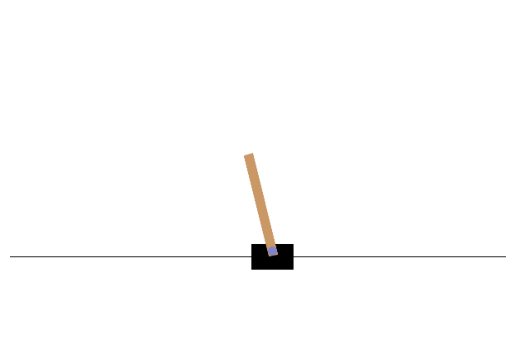

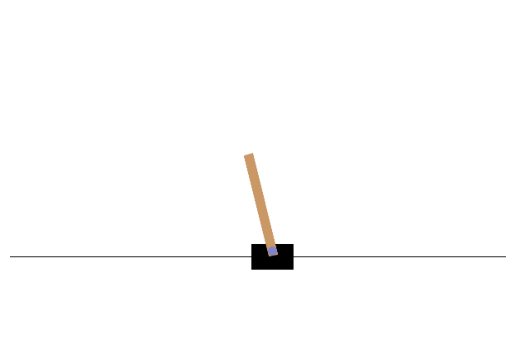

In [27]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display as ipython_display, clear_output

# Создаем среду CartPole
env = gym.make('CartPole-v1')

# Инициализируем состояние
state = env.reset()

done = False
while not done:
    action = np.random.choice(env.action_space.n)  # Выбираем случайное действие
    next_state, reward, done, _ = env.step(action)

    # Рендерим и показываем кадр
    img = env.render(mode='rgb_array')  # Захватываем изображение
    plt.imshow(img)
    plt.axis('off')  # Убираем оси
    clear_output(wait=True)  # Очищаем предыдущий вывод
    ipython_display(plt.gcf())  # Отображаем картинку
    plt.pause(0.01)  # Задержка для обновления кадра

env.close()


## Обратная связь
- [ ] Хочу получить обратную связь по решению